In [27]:
import graphix 
import numpy as np
from graphix import Circuit
import networkx as nx
import matplotlib.pyplot as plt

##### QFT

In [29]:
def cp(circuit, theta, control, target):
    circuit.rz(control, theta / 2)
    circuit.rz(target, theta / 2)
    circuit.cnot(control, target)
    circuit.rz(target, -1 * theta / 2)
    circuit.cnot(control, target)


def swap(circuit, a, b):
    circuit.cnot(a, b)
    circuit.cnot(b, a)
    circuit.cnot(a, b)


def qft_rotations(circuit, n):
    circuit.h(n)
    for qubit in range(n + 1, circuit.width):
        cp(circuit, np.pi / 2 ** (qubit - n), qubit, n)


def swap_registers(circuit, n):
    for qubit in range(n // 2):
        swap(circuit, qubit, n - qubit - 1)
    return circuit


def qft(circuit, n):
    for i in range(n):
        qft_rotations(circuit, i)
    swap_registers(circuit, n)


In [4]:
n = 3
print("{}-qubit QFT".format(n))
circuit = Circuit(n)

for i in range(n):
    circuit.h(i)
qft(circuit, n)

# standardize pattern
pattern = circuit.transpile()
pattern.standardize()
pattern.shift_signals()
nodes, edges = pattern.get_graph()
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")

3-qubit QFT
Number of nodes: 45
Number of edges: 51


In [5]:
import time
t1 = time.time()
tn = pattern.simulate_pattern(backend="tensornetwork")
value = tn.get_basis_amplitude(0)
t2 = time.time()
print("amplitude of |00...0> is ", value)
print("1/2^n (true answer) is", 1 / 2**n)
print("approximate execution time in seconds: ", t2 - t1)

amplitude of |00...0> is  0.12500000000000003
1/2^n (true answer) is 0.125
approximate execution time in seconds:  0.3535945415496826


##### QAOA

In [6]:
from graphix.gflow import flow 

In [23]:
def process_layer_data(graph: nx.Graph, layer_map: dict):

    node_attributes = {}; max_l = max(set(layer_map.values()))
    layer_data = {n: set() for n in range(max_l +1 )}

    for v in graph.nodes():
        # print(v); print(layer_data[v])
        node_attributes[v] = {"layer" : layer_map[v]}
        layer_data[layer_map[v]].add(v)

    return {'attribute_data' : node_attributes, 'nodes_in_layers': layer_data, 'num_layers' : max_l  }



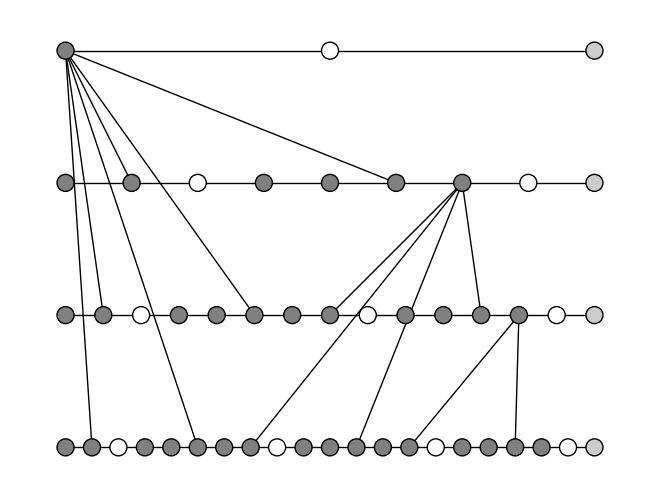

In [25]:
n =     4
xi = np.random.rand(6)
theta = np.random.rand(4)
g = nx.complete_graph(n)
circuit = Circuit(n)
for i, (u, v) in enumerate(g.edges):
    circuit.cnot(u, v)
    circuit.rz(v, xi[i])
    circuit.cnot(u, v)
for v in g.nodes:
    circuit.rx(v, theta[v])

#%%
# transpile and get the graph state

pattern = circuit.transpile()
pattern.standardize()
pattern.shift_signals()
nodes, edges = pattern.get_graph()
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

#%%
# script to specify graph node positions and colors.
#
# We work out how to place nodes on the plot, by using the flow-finding algorithm.


from graphix.gflow import flow

f, l_k = flow(g, {0, 1, 2, 3}, set(pattern.output_nodes))

flow = [[i] for i in range(4)]
for i in range(4):
    contd = True
    val = i
    while contd:
        try:
            val = f[val]
            flow[i].append(val)
        except KeyError:
            contd = False
longest = np.max([len(flow[i]) for i in range(4)])

pos = dict()
for i in range(4):
    length = len(flow[i])
    fac = longest / (length - 1)
    for j in range(len(flow[i])):
        pos[flow[i][j]] = (fac * j, -i)

# determine wheher or not a node will be measured in Pauli basis
def get_clr_list(pattern):
    nodes, edges = pattern.get_graph()
    meas_list = pattern.get_measurement_commands()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    clr_list = []
    for i in g.nodes:
        for cmd in meas_list:
            if cmd[1] == i:
                if cmd[3] in [-1, -0.5, 0, 0.5, 1]:
                    clr_list.append([0.5, 0.5, 0.5])
                else:
                    clr_list.append([1, 1, 1])
        if i in pattern.output_nodes:
            clr_list.append([0.8, 0.8, 0.8])
    return clr_list




graph_params = {"with_labels": False, "node_size": 150, "node_color": get_clr_list(pattern), "edgecolors": "k"}
nx.draw(g, pos=pos, **graph_params)


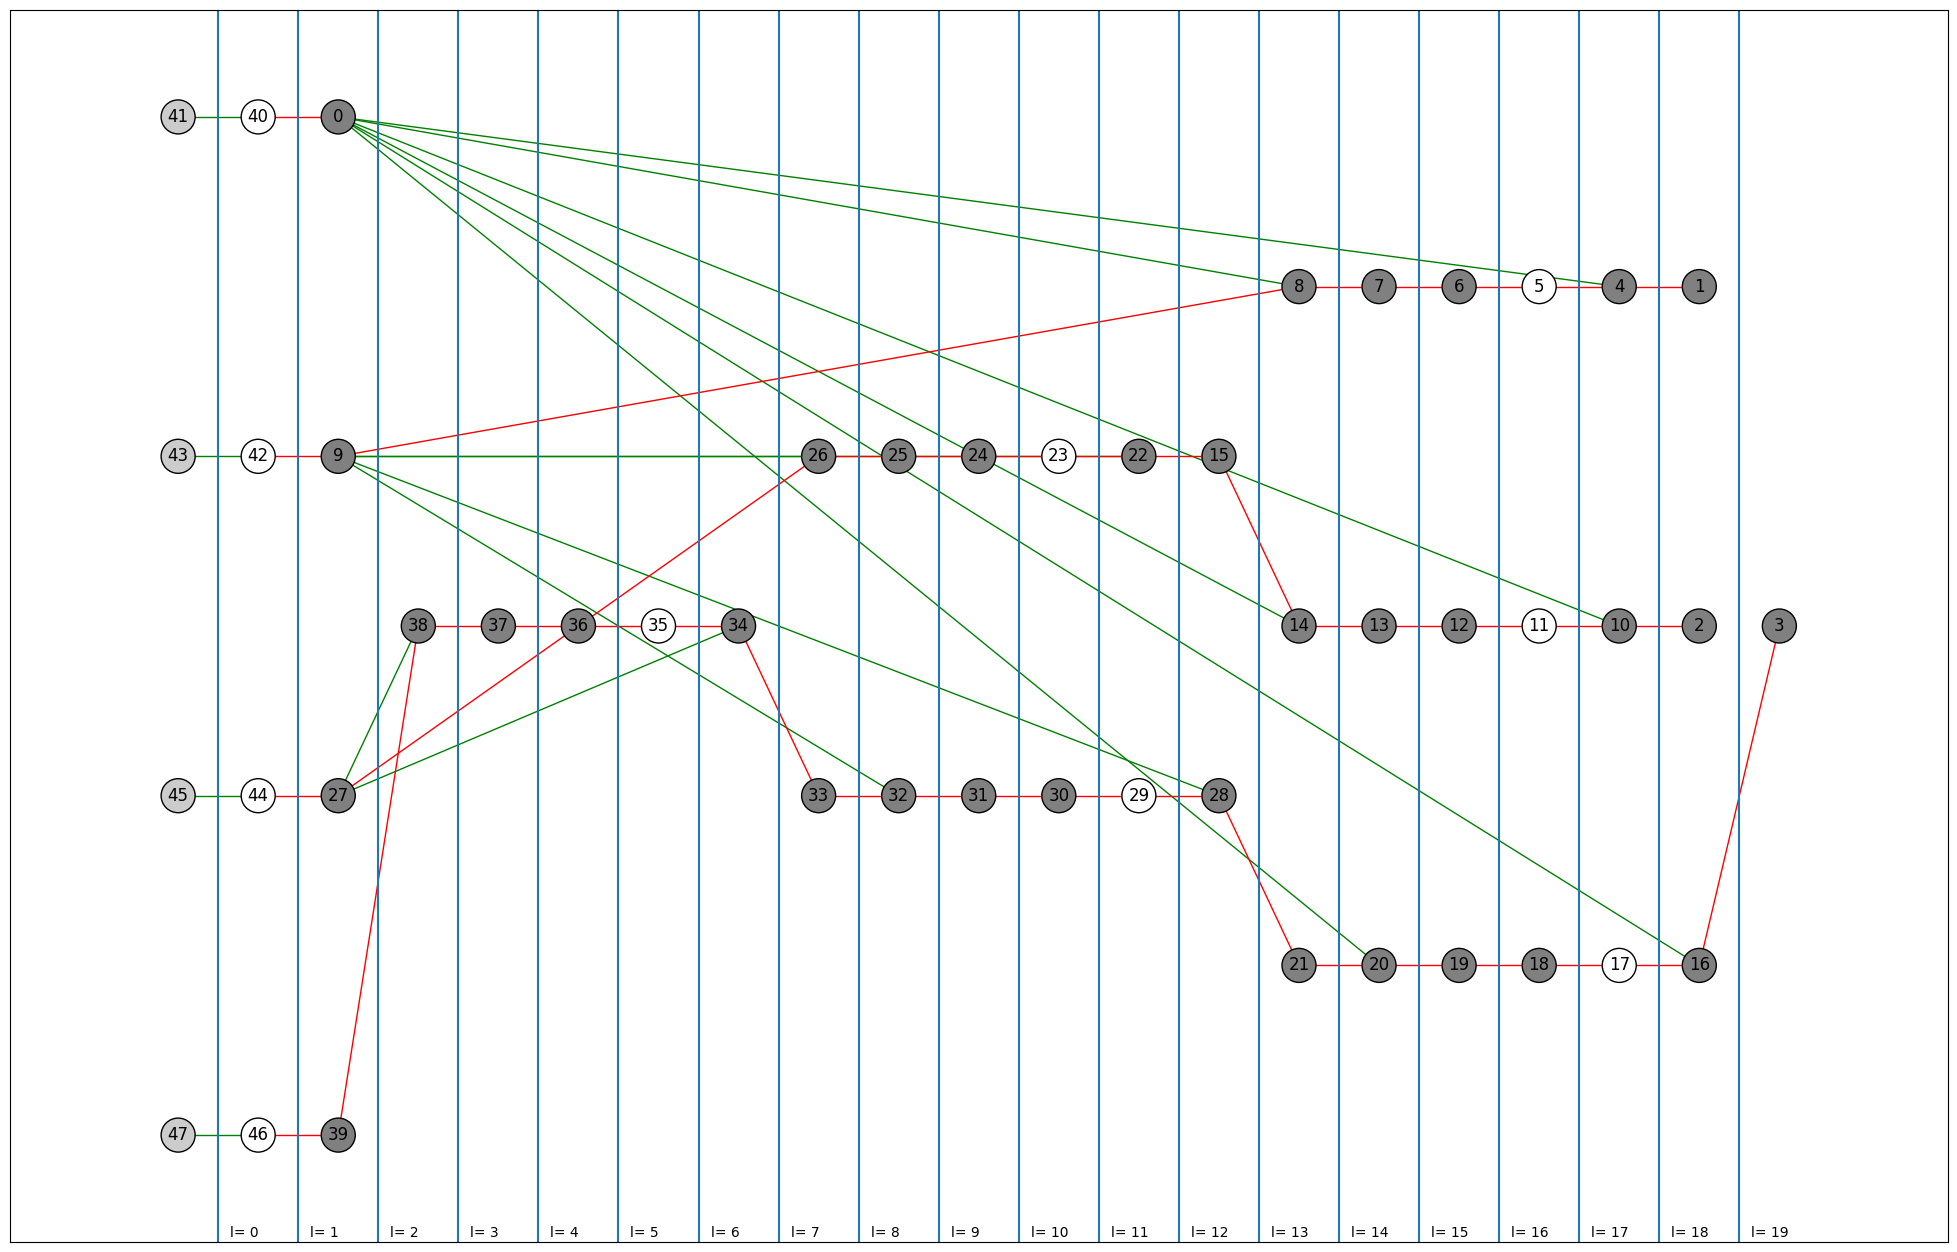

In [26]:
layer_data = process_layer_data(g, l_k)

nx.set_node_attributes(g, layer_data['attribute_data'])

graph_params = {"with_labels": True, "node_size": 600, "node_color": get_clr_list(pattern), "edgecolors": "k"}
pos = nx.multipartite_layout(g, subset_key= 'layer', align='vertical', scale= 100)

plt.figure(figsize=(25,16))

for layer in range(layer_data['num_layers']):   
    vertx_1 = next(iter(layer_data['nodes_in_layers'][layer])); xcoord_1 = pos[vertx_1][0]
    vertx_2 = next(iter(layer_data['nodes_in_layers'][layer + 1])); xcoord_2 = pos[vertx_2][0]
    xcoord = np.mean([xcoord_1, xcoord_2])
    plt.axvline(xcoord)
    plt.text(x= xcoord + 1.5, y= -18, s= 'l= ' + str(layer) )

edge_color= []
for u,v in g.edges():
      if( u not in pattern.output_nodes and v not in pattern.output_nodes ) :
        # print (u,v, u==f[v] or v== f[u])
        if u==f[v] or v== f[u] :
            edge_color.append('r')
        else :
            edge_color.append('g')


nx.draw_networkx(g, pos= pos, **graph_params, edge_color = edge_color)
# nx.draw_networkx_labels(g,pos, labels= {n:lab['layer'] for n,lab in layer_data.items() if n in pos});          

In [17]:
l_k[21]

14

In [16]:
g.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47))

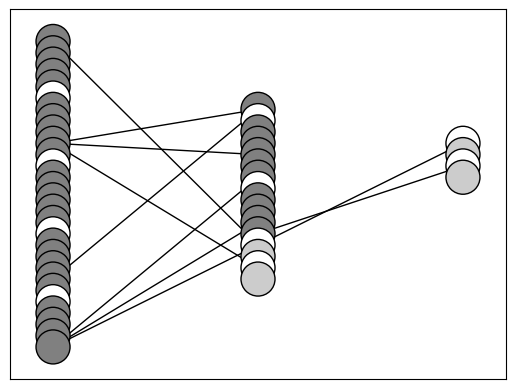

In [ ]:
G = nx.complete_multipartite_graph(28, 16, 10)
pos = nx.multipartite_layout(G)
nx.draw_networkx(g, pos= pos, **graph_params)

In [ ]:
G.nodes.data()

NodeDataView({0: {'subset': 0}, 1: {'subset': 0}, 2: {'subset': 0}, 3: {'subset': 0}, 4: {'subset': 0}, 5: {'subset': 0}, 6: {'subset': 0}, 7: {'subset': 0}, 8: {'subset': 0}, 9: {'subset': 0}, 10: {'subset': 0}, 11: {'subset': 0}, 12: {'subset': 0}, 13: {'subset': 0}, 14: {'subset': 0}, 15: {'subset': 0}, 16: {'subset': 0}, 17: {'subset': 0}, 18: {'subset': 0}, 19: {'subset': 0}, 20: {'subset': 0}, 21: {'subset': 0}, 22: {'subset': 0}, 23: {'subset': 0}, 24: {'subset': 0}, 25: {'subset': 0}, 26: {'subset': 0}, 27: {'subset': 0}, 28: {'subset': 1}, 29: {'subset': 1}, 30: {'subset': 1}, 31: {'subset': 1}, 32: {'subset': 1}, 33: {'subset': 1}, 34: {'subset': 1}, 35: {'subset': 1}, 36: {'subset': 1}, 37: {'subset': 1}, 38: {'subset': 1}, 39: {'subset': 1}, 40: {'subset': 1}, 41: {'subset': 1}, 42: {'subset': 1}, 43: {'subset': 1}, 44: {'subset': 2}, 45: {'subset': 2}, 46: {'subset': 2}, 47: {'subset': 2}, 48: {'subset': 2}, 49: {'subset': 2}, 50: {'subset': 2}, 51: {'subset': 2}, 52: {'su

In [ ]:
g.nodes.data()

NodeDataView({0: {'layer': 18}, 1: {'layer': 1}, 2: {'layer': 1}, 3: {'layer': 0}, 4: {'layer': 2}, 5: {'layer': 3}, 6: {'layer': 4}, 7: {'layer': 5}, 8: {'layer': 6}, 9: {'layer': 18}, 10: {'layer': 2}, 11: {'layer': 3}, 12: {'layer': 4}, 13: {'layer': 5}, 14: {'layer': 6}, 15: {'layer': 7}, 16: {'layer': 1}, 17: {'layer': 2}, 18: {'layer': 3}, 19: {'layer': 4}, 20: {'layer': 5}, 21: {'layer': 6}, 22: {'layer': 8}, 23: {'layer': 9}, 24: {'layer': 10}, 25: {'layer': 11}, 26: {'layer': 12}, 27: {'layer': 18}, 28: {'layer': 7}, 29: {'layer': 8}, 30: {'layer': 9}, 31: {'layer': 10}, 32: {'layer': 11}, 33: {'layer': 12}, 34: {'layer': 13}, 35: {'layer': 14}, 36: {'layer': 15}, 37: {'layer': 16}, 38: {'layer': 17}, 39: {'layer': 18}, 40: {'layer': 19}, 41: {'layer': 20}, 42: {'layer': 19}, 43: {'layer': 20}, 44: {'layer': 19}, 45: {'layer': 20}, 46: {'layer': 19}, 47: {'layer': 20}})